In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import io
import os
import re
import string
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (
  Embedding,Input,LSTM,Input,Conv2D,Softmax,Dropout,Dense,GRU,
  MaxPooling2D,LayerNormalization,Reshape,BatchNormalization,Bidirectional)
from tensorflow.keras.optimizers import Adam

In [2]:
print('Tensorflow => ',tf.__version__)
print('Keras      => ',tf.keras.__version__)
print('Numpy      => ',np.__version__)

Tensorflow =>  2.10.0
Keras      =>  2.10.0
Numpy      =>  1.25.2


In [4]:
gpus = tf.config.list_physical_devices('GPU')
gpus[0]
tf.config.experimental.set_memory_growth(gpus[0], True)

In [5]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
#import requests
from keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.compat.v1.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2

In [3]:
BATCH_SIZE=8
LR=1e-4
FRAME_LENGTH=255
FRAME_STEP=128
N_EPOCHS=100

# Noisy Data

## Data Visualization

In [4]:
audio_binary=tf.io.read_file("D:/CDAC/Datasets/DenoisingAudioCollection/noisy_trainset_56spk_wav/noisy_trainset_56spk_wav/p234_021.wav")
audio,_=tf.audio.decode_wav(audio_binary)
waveform=tf.squeeze(audio,axis=-1)
waveform=tf.cast(waveform,tf.float32)
signal=waveform
print(signal.shape)

(124320,)


(124320,)


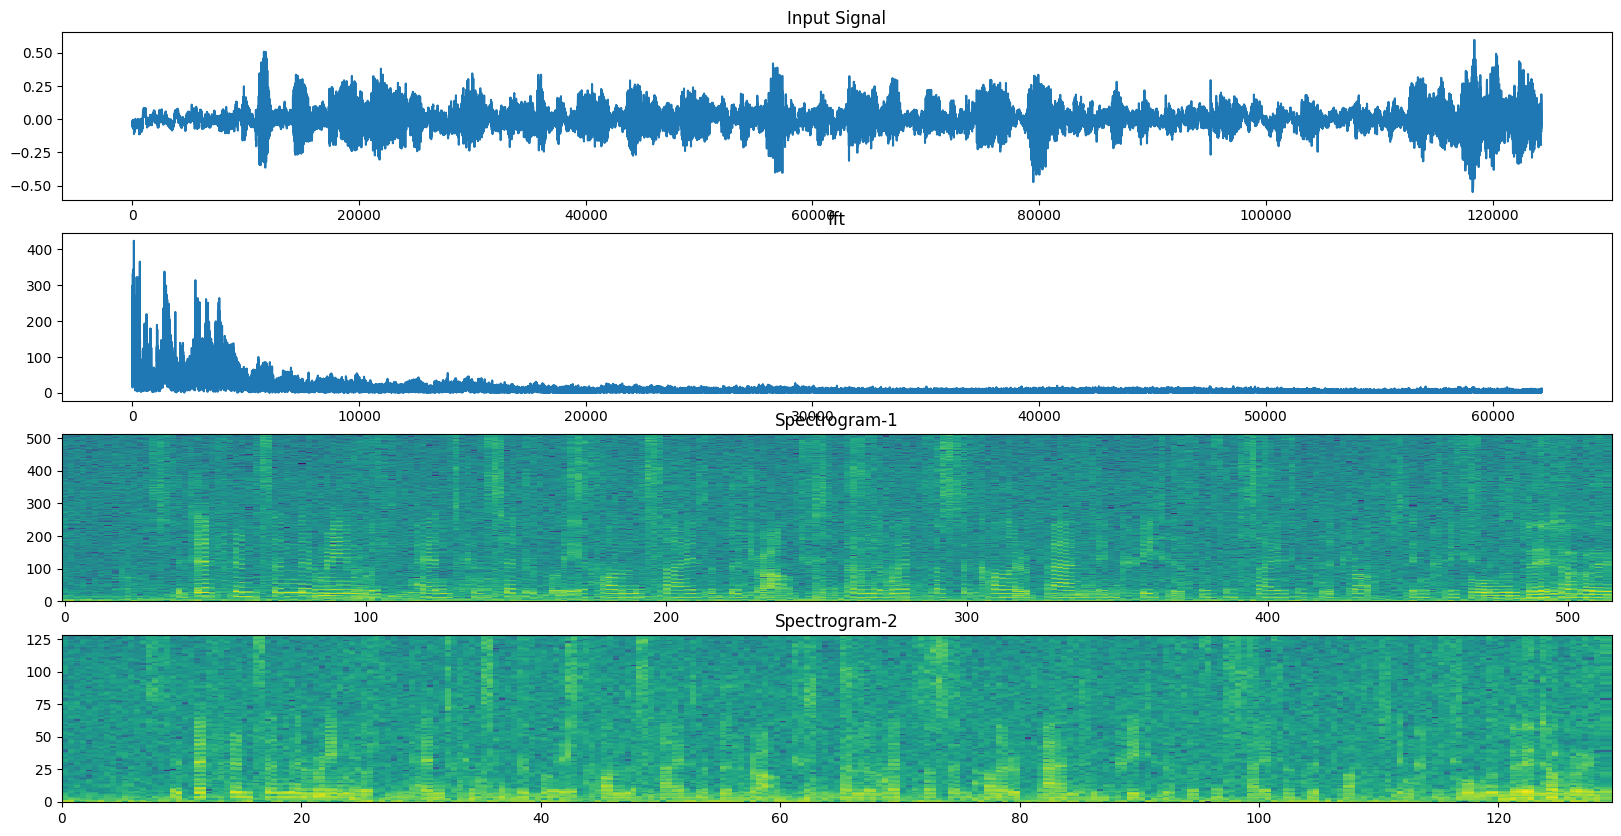

In [5]:
fig,axis=plt.subplots(4,figsize=(20,10))

L=2000
x=tf.linspace(-L//2,L//2,L)
print(signal.shape)
axis[0].plot(signal)
axis[0].set_title("Input Signal")

fft=tf.signal.rfft(signal)

axis[1].plot(tf.abs(fft))
axis[1].set_title("fft")


spec=tf.signal.stft(signal,frame_length=1024,frame_step=512,)
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[2].pcolormesh(X,Y,power_spec)
axis[2].set_title("Spectrogram-1")


spec=tf.signal.stft(signal,frame_length=256,frame_step=128, )
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[3].pcolormesh(X,Y,power_spec)
axis[3].set_title("Spectrogram-2")


plt.show()


In [6]:
Y

range(0, 129)

In [7]:
X

array([  0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   1,   1,   1,
         1,   1,   1,   2,   2,   2,   2,   2,   2,   2,   3,   3,   3,
         3,   3,   3,   3,   3,   4,   4,   4,   4,   4,   4,   4,   5,
         5,   5,   5,   5,   5,   5,   5,   6,   6,   6,   6,   6,   6,
         6,   7,   7,   7,   7,   7,   7,   7,   7,   8,   8,   8,   8,
         8,   8,   8,   9,   9,   9,   9,   9,   9,   9,   9,  10,  10,
        10,  10,  10,  10,  10,  11,  11,  11,  11,  11,  11,  11,  11,
        12,  12,  12,  12,  12,  12,  12,  13,  13,  13,  13,  13,  13,
        13,  13,  14,  14,  14,  14,  14,  14,  14,  15,  15,  15,  15,
        15,  15,  15,  15,  16,  16,  16,  16,  16,  16,  16,  17,  17,
        17,  17,  17,  17,  17,  17,  18,  18,  18,  18,  18,  18,  18,
        19,  19,  19,  19,  19,  19,  19,  19,  20,  20,  20,  20,  20,
        20,  20,  21,  21,  21,  21,  21,  21,  21,  21,  22,  22,  22,
        22,  22,  22,  22,  23,  23,  23,  23,  23,  23,  23,  2

## Data Preparation

In [11]:
#not working
import tensorflow_io as tfio

def reSample(file) :
  rateOut=16000  
  audioIOTensor = tfio.audio.AudioIOTensor(file)  
  print(audioIOTensor.shape)
  chanalsIn=(int)(audioIOTensor.shape[1])
  rateIn=(int)(audioIOTensor.rate)
  print(audioIOTensor.shape[1])
  audioTensor = audioIOTensor[0:] #get audio block  

  if (chanalsIn>1): #sterio to mono
    audioTensor=audioTensor.numpy()
    audioTensor=np.average(audioTensor,axis=1)
    audio_slice=tf.convert_to_tensor(audioTensor)

  print(audioTensor.shape)

  #change rate
  audioTensor=tfio.audio.resample(audioTensor, rateIn,rateOut)

  print(audioTensor.shape)


  # remove last dimension
  #audioTensor = tf.squeeze(audioTensor, axis=[1])
  # convert to wav and save 
  #wav = tf.cast(audioTensor, tf.float32) / 32768.0
  print(audioTensor.shape)
  audioTensor=tf.expand_dims(audioTensor, axis=1)  # add axis for tf.audio.encode_wav
  print(audioTensor.shape)
  outWavAudio=tf.audio.encode_wav(audio=audioTensor,sample_rate=rateOut)
      
  tf.io.write_file(file,outWavAudio)

In [12]:
from pydub import AudioSegment as am
def reSample2(filePath) :
    sound = am.from_file(filePath, format='wav', frame_rate=getSamplingRate(filePath))
    sound = sound.set_frame_rate(16000)
    sound.export(filePath, format='wav')

c:\Users\Anand\miniconda3\envs\tf_gpu\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [8]:
path1="D:/CDAC/Datasets/DenoisingAudioCollection/noisy_trainset_56spk_wav/noisy_trainset_56spk_wav"
dir_list1 = os.listdir(path1)
dir_list1

['p234_001.wav',
 'p234_002.wav',
 'p234_003.wav',
 'p234_004.wav',
 'p234_005.wav',
 'p234_006.wav',
 'p234_007.wav',
 'p234_008.wav',
 'p234_009.wav',
 'p234_010.wav',
 'p234_012.wav',
 'p234_013.wav',
 'p234_014.wav',
 'p234_015.wav',
 'p234_016.wav',
 'p234_017.wav',
 'p234_018.wav',
 'p234_019.wav',
 'p234_020.wav',
 'p234_021.wav',
 'p234_022.wav',
 'p234_023.wav',
 'p234_024.wav',
 'p234_025.wav',
 'p234_026.wav',
 'p234_027.wav',
 'p234_028.wav',
 'p234_029.wav',
 'p234_030.wav',
 'p234_031.wav',
 'p234_032.wav',
 'p234_033.wav',
 'p234_034.wav',
 'p234_035.wav',
 'p234_036.wav',
 'p234_037.wav',
 'p234_038.wav',
 'p234_039.wav',
 'p234_040.wav',
 'p234_041.wav',
 'p234_042.wav',
 'p234_043.wav',
 'p234_044.wav',
 'p234_045.wav',
 'p234_046.wav',
 'p234_047.wav',
 'p234_048.wav',
 'p234_049.wav',
 'p234_050.wav',
 'p234_051.wav',
 'p234_052.wav',
 'p234_053.wav',
 'p234_054.wav',
 'p234_055.wav',
 'p234_056.wav',
 'p234_057.wav',
 'p234_058.wav',
 'p234_059.wav',
 'p234_060.wav

In [15]:
from scipy.io.wavfile import read as read_wav
import os
#os.chdir('path') # change to the file directory

def getSamplingRate(filePath):
    sampling_rate, data=read_wav(filePath) # enter your filename
    return sampling_rate

In [16]:
for wavFile in dir_list1:  
    reSample2("D:/CDAC/Datasets/DenoisingAudioCollection/noisy_trainset_56spk_wav/noisy_trainset_56spk_wav/"+wavFile)

In [9]:
audio_text2={}
path="D:/CDAC/Datasets/DenoisingAudioCollection/trainset_56spk_txt/trainset_56spk_txt"
dir_list = os.listdir(path)
dir_list


['p234_001.txt',
 'p234_002.txt',
 'p234_003.txt',
 'p234_004.txt',
 'p234_005.txt',
 'p234_006.txt',
 'p234_007.txt',
 'p234_008.txt',
 'p234_009.txt',
 'p234_010.txt',
 'p234_012.txt',
 'p234_013.txt',
 'p234_014.txt',
 'p234_015.txt',
 'p234_016.txt',
 'p234_017.txt',
 'p234_018.txt',
 'p234_019.txt',
 'p234_020.txt',
 'p234_021.txt',
 'p234_022.txt',
 'p234_023.txt',
 'p234_024.txt',
 'p234_025.txt',
 'p234_026.txt',
 'p234_027.txt',
 'p234_028.txt',
 'p234_029.txt',
 'p234_030.txt',
 'p234_031.txt',
 'p234_032.txt',
 'p234_033.txt',
 'p234_034.txt',
 'p234_035.txt',
 'p234_036.txt',
 'p234_037.txt',
 'p234_038.txt',
 'p234_039.txt',
 'p234_040.txt',
 'p234_041.txt',
 'p234_042.txt',
 'p234_043.txt',
 'p234_044.txt',
 'p234_045.txt',
 'p234_046.txt',
 'p234_047.txt',
 'p234_048.txt',
 'p234_049.txt',
 'p234_050.txt',
 'p234_051.txt',
 'p234_052.txt',
 'p234_053.txt',
 'p234_054.txt',
 'p234_055.txt',
 'p234_056.txt',
 'p234_057.txt',
 'p234_058.txt',
 'p234_059.txt',
 'p234_060.txt

In [10]:
for file in dir_list:  
  i=str(file)
  i=i.replace(".txt","")  
  with open(path+'/'+file, encoding="utf-8") as f:    
    text=f.readline().removesuffix("/n")
    text=text.replace(".   ",".")
    text=text.replace(".  ",".")
    text=text.replace(". ",".")
    audio_text2[str(i)]=text
  f.close

audio_text2

{'p234_001': 'Please call Stella.\n',
 'p234_002': 'Ask her to bring these things with her from the store.\n',
 'p234_003': 'Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.\n',
 'p234_004': 'We also need a small plastic snake and a big toy frog for the kids.\n',
 'p234_005': 'She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.\n',
 'p234_006': 'When the sunlight strikes raindrops in the air, they act as a prism and form a rainbow.\n',
 'p234_007': 'The rainbow is a division of white light into many beautiful colors.\n',
 'p234_008': 'These take the shape of a long round arch, with its path high above, and its two ends apparently beyond the horizon.\n',
 'p234_009': 'There is , according to legend, a boiling pot of gold at one end.\n',
 'p234_010': 'People look, but no one ever finds it.\n',
 'p234_012': 'Throughout the centuries people have explained the rainbow in various ways.\n

In [11]:
filepaths=["D:/CDAC/Datasets/DenoisingAudioCollection/noisy_trainset_56spk_wav/noisy_trainset_56spk_wav/"+filename+".wav" for filename in list(audio_text2.keys())]
transcriptions=[audio_text2[str(filename)].lower() for filename in list(audio_text2.keys())]
print(len(filepaths))
print(len(transcriptions))

23075
23075


In [12]:
dataset=tf.data.Dataset.from_tensor_slices((filepaths,transcriptions))

for i in dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'D:/CDAC/Datasets/DenoisingAudioCollection/noisy_trainset_56spk_wav/noisy_trainset_56spk_wav/p234_001.wav'>, <tf.Tensor: shape=(), dtype=string, numpy=b'please call stella.\n'>)


In [13]:
def decode_audio(audio_binary):
    audio,_=tf.audio.decode_wav(audio_binary)    
    return tf.squeeze(audio,axis=-1)

In [14]:
vocabulary=[""]+[chr(i) for i in range(97,97+26)]+[".",",","?"," "]
print(vocabulary)
print(len(vocabulary))

['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.', ',', '?', ' ']
31


In [15]:
def get_label(label,):
    label=tf.strings.unicode_split(label, input_encoding="UTF-8")
    label=tf.keras.layers.StringLookup(vocabulary=vocabulary, oov_token="")(label)
    return label

In [16]:
def get_spec(filepath,label):

  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)

  spectrogram=tf.signal.stft(
  waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)
  spectrogram=tf.abs(spectrogram)
  label=get_label(label)
  return tf.expand_dims(spectrogram,axis=-1),label

In [17]:
processed_dataset = (
    dataset.map(get_spec, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [18]:
train_dataset=processed_dataset.take(int(0.95*len(processed_dataset)))
val_dataset=processed_dataset.skip(int(0.95*len(processed_dataset)))

In [19]:
for i,j in train_dataset.take(1):
  print(i,j)

tf.Tensor(
[[[[6.86011761e-02]
   [3.37277740e-01]
   [2.65849978e-01]
   ...
   [4.35622875e-03]
   [1.62063644e-03]
   [3.74482200e-03]]

  [[3.41385722e-01]
   [3.42282623e-01]
   [3.38700444e-01]
   ...
   [7.45417178e-03]
   [7.63005344e-03]
   [7.81430304e-03]]

  [[7.04963863e-01]
   [2.49136478e-01]
   [4.87697750e-01]
   ...
   [3.36440606e-03]
   [1.74826989e-03]
   [2.55644321e-04]]

  ...

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]

  [[0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]
   ...
   [0.00000000e+00]
   [0.00000000e+00]
   [0.00000000e+00]]]


 [[[1.18629956e+00]
   [9.42521036e-01]
   [5.98442376e-01]
   ...
   [6.56268001e-02]
   [5.99547587e-02]
   [4.77619171e-02]]

  [[5.54738522e-01]
   [5.78444660e-01]
   [5.72906792e-01]
   ...
   [3.7505

## Modeling 

In [20]:
normalization=tf.keras.layers.Normalization()

In [21]:
input_spectrogram=Input((None,129,1), name="input")

x=normalization(input_spectrogram)
x=Conv2D(32,kernel_size=[11,41],strides=[2,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)
x=Conv2D(64,kernel_size=[11,21],strides=[1,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)

x=Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)


output=Dense(len(vocabulary)+1, activation="softmax")(x)

model = tf.keras.Model(input_spectrogram, output, name="DeepSpeech_2_Inspired")
model.summary()

Model: "DeepSpeech_2_Inspired"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 129, 1)]    0         
                                                                 
 normalization (Normalizatio  (None, None, 129, 1)     3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, None, 65, 32)      14464     
                                                                 
 layer_normalization (LayerN  (None, None, 65, 32)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, None, 33, 64)      473152    
                                                                 
 layer_normalization_1 (Laye  (None, None, 33

In [22]:
def ctc_loss(y_true,y_pred):
  batch_size=tf.shape(y_pred)[0]
  pred_length=tf.shape(y_pred)[1]
  true_length=tf.shape(y_true)[1]

  pred_length=pred_length*tf.ones([batch_size,1],dtype=tf.int32)
  true_length=true_length*tf.ones([batch_size,1],dtype=tf.int32)

  return tf.keras.backend.ctc_batch_cost(y_true,y_pred,pred_length,true_length)

In [23]:
model.compile(
    loss=ctc_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
)

In [24]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("ASR_Noisy_56spk_Model-{epoch:03d}.h5")
model_path='D:/CDAC/Project/ASR-using-deepspeech2/ASR_Noisy_56spk_Model_Final.h5'

## Training

In [33]:
history=model.fit(
  train_dataset,
  validation_data=val_dataset,
  verbose=1,
  epochs=N_EPOCHS,  
  callbacks=[checkpoint_cb]  
)

Epoch 1/100
2740/2740 [==============================] - 663s 238ms/step - loss: 119.0128 - val_loss: 108.5809
Epoch 2/100
2740/2740 [==============================] - 456s 166ms/step - loss: 114.3408 - val_loss: 107.4822
Epoch 3/100
2740/2740 [==============================] - 445s 162ms/step - loss: 111.6856 - val_loss: 101.4514
Epoch 4/100
2740/2740 [==============================] - 444s 162ms/step - loss: 104.5617 - val_loss: 97.9512
Epoch 5/100
2740/2740 [==============================] - 444s 162ms/step - loss: 98.9328 - val_loss: 89.7044
Epoch 6/100
2740/2740 [==============================] - 448s 163ms/step - loss: 84.8328 - val_loss: 81.9330
Epoch 7/100
2740/2740 [==============================] - 451s 164ms/step - loss: 75.7533 - val_loss: 77.8962
Epoch 8/100
2740/2740 [==============================] - 463s 169ms/step - loss: 70.0160 - val_loss: 74.8949
Epoch 9/100
2740/2740 [==============================] - 462s 169ms/step - loss: 65.5363 - val_loss: 74.0756
Epoch 10/100

In [34]:
# save model
model.save(model_path)

## Testing

In [25]:
model.load_weights('D:/CDAC/Project/ASR-using-deepspeech2/ASR_Noisy_56spk_Model_Final.h5')

In [26]:
#obtain and decode the acoustic model's predictions
model.load_weights(model_path)

In [27]:
def get_spec_inference(filepath):

  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)

  spectrogram=tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)

  spectrogram=tf.abs(spectrogram)

  return tf.expand_dims(spectrogram,axis=-1)

In [28]:
def decode(y_pred):
  batch_size=tf.shape(y_pred)[0]
  print(tf.shape(y_pred))

  pred_length=tf.shape(y_pred)[1]
  pred_length*=tf.ones([batch_size,],dtype=tf.int32)

  y_pred=tf.one_hot(y_pred,len(vocabulary)+1)
  output=tf.keras.backend.ctc_decode(y_pred,input_length=pred_length,greedy=True)[0][0]

  out=[vocabulary[i] for i in output[0]]
  return ''.join(out)

In [29]:
test_path="D:/CDAC/Datasets/DenoisingAudioCollection/noisy_trainset_56spk_wav/noisy_trainset_56spk_wav/p234_089.wav"
from IPython.display import Audio
# play the audio file
Audio(test_path)

In [56]:
getSamplingRate(test_path)

16000

In [30]:
spectrogram=get_spec_inference(test_path)
print(spectrogram.shape)
out=tf.argmax(model.predict(tf.expand_dims(spectrogram,axis=0))[0],axis=1)
out

(232, 129, 1)
1/1 [==============================] - 11s 11s/step


<tf.Tensor: shape=(116,), dtype=int64, numpy=
array([23,  8,  1, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 20, 20, 20, 20, 30, 30,  4, 31,  9, 31, 31, 31, 31, 30, 30,
       30, 23,  5, 31, 31, 31, 30, 30,  4, 31, 15, 31, 31, 31, 31, 31, 31,
       31, 14,  7, 31, 31, 29, 31, 31, 31, 31,  0, 31, 31, 31, 31, 31, 31,
       31,  0, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31,  0, 31, 31, 31, 31, 31,  0],
      dtype=int64)>

In [31]:
out_list=[vocabulary[i] if i!=31 else "[LINK]" for i in out]
out_str="".join(out_list)
print(out_str)

wha[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]tttt  d[LINK]i[LINK][LINK][LINK][LINK]   we[LINK][LINK][LINK]  d[LINK]o[LINK][LINK][LINK][LINK][LINK][LINK][LINK]ng[LINK][LINK]?[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]


In [32]:
transcription=decode(tf.expand_dims(out,axis=0))
print(transcription)

tf.Tensor([  1 116], shape=(2,), dtype=int32)
what di we dong?                                                                                                


In [60]:
#%pip list

In [33]:
# !pip install pyspellchecker
from spellchecker import SpellChecker

spelling = SpellChecker()
def spelling_checks(text):
  correct_result = []
  typo_words = spelling.unknown(text.replace(".","").split())
  for word in text.split():
    if word in typo_words:
      newWord=spelling.correction(word)
      if newWord!=None:
        correct_result.append(newWord)
      else:
        correct_result.append(word)
    else:
      correct_result.append(word)
  return " ".join(correct_result)

corrected_transcription=spelling_checks(transcription)
print(corrected_transcription)

what i we dong
